# Imports

## Import Packages

In [2]:
import pandas as pd
import numpy as np
from fontTools.subset import intersect
from pandas import read_csv
from scipy.stats import chi2_contingency, norm, chi2
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

## Import Functions

In [3]:
from src.K_Means_optimisation_GenePy import KM_opt, KM_opt_stabl, KM, KM_random, compute_ari_matrix, KM_RF, merge_phen_genepy, compute_clustering_metrics
from src.cluster_enrichment_analysis import analyze_cluster_deviations
from src.Plotting import plotk, plot_ari_heatmap, plot_clustering_metrics

## Import SPARC IBD CADD15 GenePy Matrix

In [4]:
#Import SPARC IBD CADD15 GenePy matrix
SPARC_IBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/IBD Plexus/GenePy/sparc_ibd_ccds_CADD15_merged_filt_mmscaled.matrix")

#Set samid as index
SPARC_IBD_CADD15_GenePy = SPARC_IBD_CADD15_GenePy.set_index("samid")

## Import Southampton IBD CADD15 GenePy Matrix

In [5]:
# Import Soton Local IBD CADD15 GenePy matrix
#dtype_dict = {"Gender": "object", "Age at diagnosis": "float64",
#              'Diagnosis': "object", "Stricturing": "object", "Fistulating": "object",
#              'Granuloma': "object", 'IBD Surgery': 'int64', 'IBD phenotype': 'object'}

SotonIBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/Soton Local IBD/GenePy/jcmar24_IBD_CADD15_merged_filt_mmscaled.matrix"
                                       #,dtype=dtype_dict
                                       )

#Set samid as index
SotonIBD_CADD15_GenePy = SotonIBD_CADD15_GenePy.set_index("Samid")

#SotonIBD_CADD15_GenePy = SotonIBD_CADD15_GenePy[SotonIBD_CADD15_GenePy['Diagnosis'] != "NOT_IBD"]

## Import Gene Lists

In [142]:
NOD_sig_genes9 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes9.txt")
NOD_sig_genes13 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes13.txt")
NOD_sig_genes43 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes43.txt")
JAK_STAT_sig_genes_30 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/JAK_STAT_sig_genes30.txt")
IL10_sig_genes_49 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL10_sig_genes49.txt")
IL23_sig_genes_20 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL23_genes20.txt")
Th17_sig_genes_11 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/Th17_genes11.txt") #All of these genes are in the list of 20 IL-23 signalling genes
NADPH_genes_12 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NADPH_sig_genes12.txt")
NADPH_genes_36 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NADPH_sig_genes36.txt")

In [ ]:
NOD2_gene = NOD_sig_genes9.loc[NOD_sig_genes9['Gene name'] == 'NOD2',:]
NOD_sig_genes9_noNOD2 = NOD_sig_genes9.loc[NOD_sig_genes9['Gene name'] != 'NOD2',:]

### IBD Consensus Pathways

In [4]:
IBD_consensus_paths = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Progression Reviews/Confirmation Progression Review/Supp material/Consensus IBD pathway genes.txt")
IBD_union_genes = IBD_consensus_paths.loc[(IBD_consensus_paths['NOD signalling consensus 2'] == 1) | (IBD_consensus_paths['IL-10 signalling consensus 2'] == 1) | (IBD_consensus_paths['IL-23 signalling consensus 2'] == 1) |
(IBD_consensus_paths['Th17 differentiation consensus 2']) | (IBD_consensus_paths['JAK-STAT consensus 2'] == 1) | (IBD_consensus_paths['NADPH oxidases consensus 2'] == 1),:]
IBD_union_genes = IBD_union_genes.iloc[:,list(range(0,4)) + [11] + [13] + [15] +[17] + [19] + [21]]
IBD_union_genes.loc[IBD_union_genes['Gene name'] == 'NOXO1', 'Gene stable ID'] = "ENSG00000196408"

In [7]:
IBD_union_genes['GenePy gene'] = IBD_union_genes['Gene stable ID'] + "_" + IBD_union_genes['Gene name'] + "_CADD15_matrix"
IBD_union_genes_sparc = IBD_union_genes.loc[:,['Gene stable ID', 'Gene name', 'GenePy gene']]

In [10]:
IBD_union_genes_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IBD_union_genes.txt", index=False, sep='\t')

# SPARC IBD

## NOD2

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD2_gene, 50, cohort_name='SPARC')

In [ ]:
plotk(results_df, [18,37, 47])

In [ ]:
#k = 18
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD2_gene, 18)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
#Get list of patients with no NOD2 signal
SPARC_GenePy_0_NOD2_samid = km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 1]['Samid']
SPARC_GenePy_0_NOD2_samid

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_NOD2_18C_genepy.txt", sep='\t', index=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['Crohn s disease phenotype']['overall_p_value'])
print(results_df['IBD surgery final']['overall_p_value'])

In [ ]:
results_df['IBD surgery final']['corr_p_values_chi2'] #.keys()

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 10]['ENSG00000167207_NOD2_CADD15_matrix'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 10]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 3) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['Crohn s disease phenotype'].value_counts()

## 9 NOD Signalling Genes

In [29]:
#Optimise k based on silhouette score and DBI
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='SPARC')

In [31]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.642724,0.626674,2827
1,3,0.304913,2.691593,1937
2,4,0.334981,2.172020,1856
3,5,0.348728,1.834343,1828
4,6,0.372934,1.605035,1783
5,7,0.346492,1.202347,1768
6,8,0.382008,0.980082,1552
7,9,0.427225,0.898065,1498
8,10,0.418584,0.946270,1498
9,11,0.441379,0.884471,1472


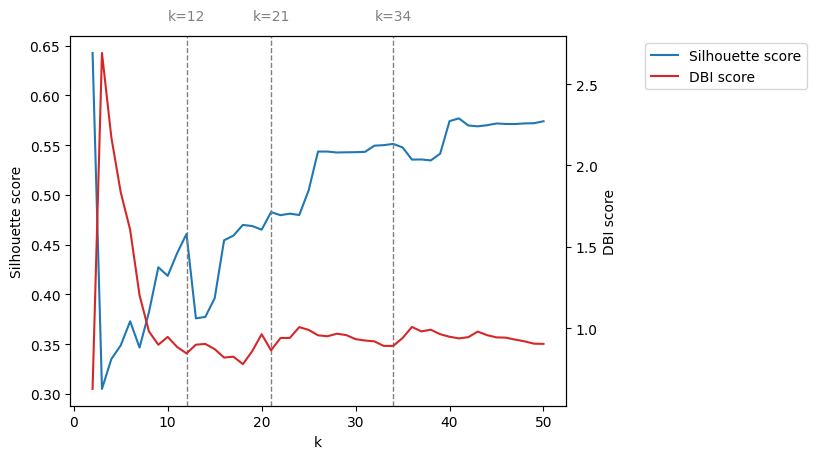

In [33]:
plotk(results_df, [12,21, 34])

In [ ]:
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 50, "SPARC", n_iter=100)
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig9_clustering_metrics.txt", sep="\t", index=False)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig9_clustering_metrics.txt", index_col=None)

In [18]:
    metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.337242,0.399296,0.011127,0.473354,0.103653,0.020671,1.074594,0.263712,0.052590
1,3,0.539238,0.241166,0.006721,0.382534,0.084391,0.016829,1.196702,0.320902,0.063995
2,4,0.545957,0.214261,0.005971,0.377521,0.076983,0.015352,1.159739,0.260720,0.051993
3,5,0.550521,0.218610,0.006092,0.379885,0.070059,0.013971,1.068165,0.197504,0.039386
4,6,0.592377,0.217334,0.006057,0.375342,0.065160,0.012994,1.005202,0.170905,0.034082
5,7,0.592562,0.224376,0.006253,0.368326,0.073223,0.014602,0.975626,0.155791,0.031068
6,8,0.696203,0.197063,0.005492,0.387613,0.057054,0.011378,0.889967,0.114370,0.022808
7,9,0.675881,0.197064,0.005492,0.390186,0.058872,0.011740,0.860476,0.114757,0.022885
8,10,0.667068,0.201932,0.005627,0.391435,0.062623,0.012488,0.842750,0.112660,0.022467
9,11,0.717038,0.187648,0.005229,0.413819,0.055379,0.011044,0.804669,0.093623,0.018671


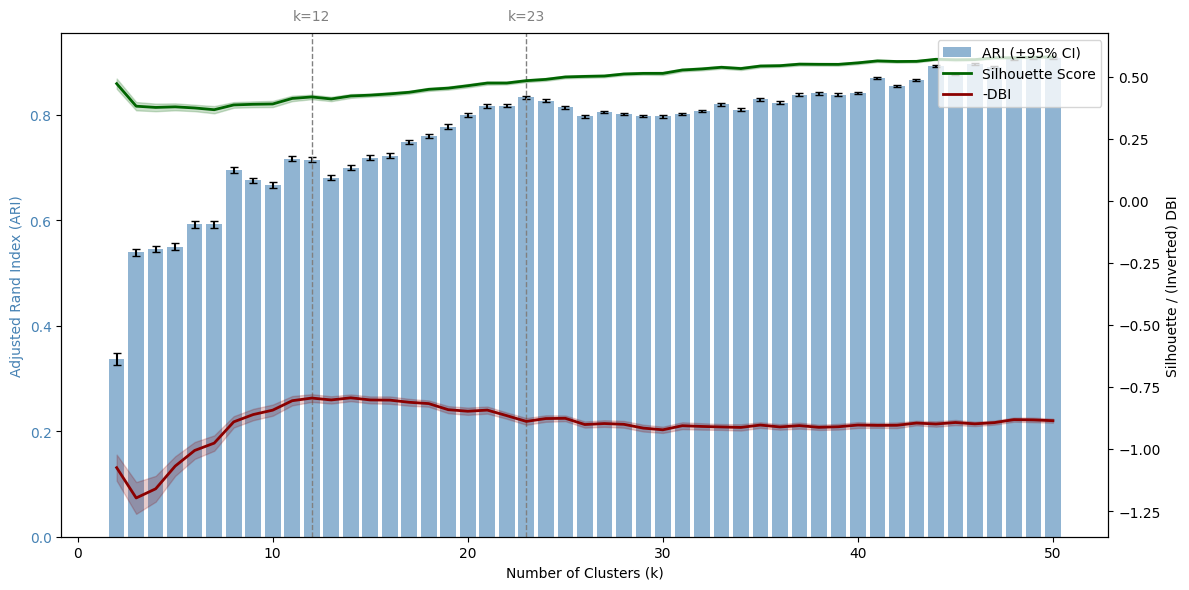

In [28]:
plot_clustering_metrics(metrics_df, vlines=[12, 23])

### K = 12

In [24]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 12)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_9F_12C_NOD_2_genepy.txt", sep='\t', index=False)

In [26]:
#km_out_sparc.value_counts()
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(1.1784342238968988e-12), np.float64(4.770868354450124e-07), np.float64(5.952817434842164e-05)]


### K = 23

In [19]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 23)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_9F_23C_NOD_2_genepy.txt", sep='\t', index=False)

In [21]:
km_out_sparc.value_counts()

Cluster
10         606
2          499
15         357
5          255
1          214
18         177
14         157
20         113
0          109
3           90
4           43
7           39
6           33
16          25
8           23
22          19
17          16
12          15
9           14
21          14
13          14
11          13
19          11
Name: count, dtype: int64

In [ ]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [ ]:
feat_imp_sparc[feat_imp_sparc['Cluster'] == 17].sort_values("Importance", ascending=False)

In [22]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [23]:
#results_df['Diagnosis']['overall_p_value'] #.keys()
#type(results_df['Diagnosis']['overall_p_value'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(5.3201358230510235e-14), np.float64(1.145967646392944e-09), np.float64(7.25978107923509e-06)]


### K = 35

In [ ]:
#For k = 21, silhouette score is 0.5126 and the DBI score is 0.8283
#k = 15; silhouette score = 0.398559; DBI = 0.923939
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 35)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_9F_35C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
feat_imp_sparc = KM_RF(km_out, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
### NOD2 analysis
#Sort clusters by feature importance of NOD2 CADD15 GenePy
feat_imp_sparc[feat_imp_sparc['Feature'] == "ENSG00000167207_NOD2_CADD15_matrix"].sort_values(by="Importance", ascending=False)

In [ ]:
feat_imp_sparc[feat_imp_sparc['Cluster'] == 17].sort_values(by="Importance", ascending=False)

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 1]['ENSG00000106100_NOD1_CADD15_matrix'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy_sparc[km_out_phen_GenePy_sparc['Cluster'] == 3]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy_sparc[(km_out_phen_GenePy_sparc['Cluster'] == 3) & (km_out_phen_GenePy_sparc['Diagnosis'] == "CD")]['Crohn s disease phenotype'].value_counts()

In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 21].value_counts(['Diagnosis', 'Crohn s disease phenotype', "IBD surgery final"])

In [ ]:
#Check raw and multiple-test-corrected p-values
results_df['Diagnosis']['p_values_chi2']#.keys()

### K = 21

In [ ]:
feat_imp = KM_RF(km_out, X)

In [ ]:
feat_imp[feat_imp['Cluster'] == 7].sort_values(by='Importance', ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Diagnosis']['corr_p_values_chi2']#.keys()

In [ ]:
#Cluster 14 - enriched for CD and depleted for UC
#193 CD/UC patients with NOD2 GenePy within 0.2607 to 0.4545, RIPK2 GenePy =< 0.1756 (192 have a score of 0) and NOD1 within 0 and 0.394107
SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.454504) &
                                             (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.394107)).astype(int)

# SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207.15_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207.15_NOD2'] <= 0.454504) &
#                                               (SotonIBD_CADD15_GenePy['ENSG00000104312.8_RIPK2'] <= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000106100.11_NOD1'] <= 0.394107)).astype(int)

In [ ]:
#Cluster 19 is depleted for UC (n = 113)
#NOD2 (47.15%) -> 0.132311-0.406112
#RIPK2 (46.16%) -> 0.175602-0.490679
#NOD1 (2.1369%) -> <= 0.127193
SotonIBD_CADD15_GenePy['cluster 19'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.132311) &
                                               (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.406112) &
                                               #(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] >= 0.175602) &
                                               #(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.490679) &
                                              (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.127193)).astype(int)

In [ ]:
#Cluster 4 is depleted for UC
#NOD2 (96.76%) -> >= 0.732
SotonIBD_CADD15_GenePy['cluster 4'] = (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.732).astype(int)

In [ ]:
#Cluster 12 -> 357 patients with NOD2 0 and CHUK 0, RIPK2 0
SotonIBD_CADD15_GenePy['cluster 12'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000213341_CHUK'] == 0)
                                            & (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] == 0)).astype(int)

In [ ]:
SotonIBD_CADD15_GenePy.loc[(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] >= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.490679),:].value_counts("ENSG00000104312_RIPK2")

## 43 NOD Signalling Genes

In [6]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, "SPARC", n_iter=100)
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig43_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [20]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.322185,3.627469,2549
1,3,0.174950,2.355673,2333
2,4,0.178354,2.774589,2170
3,5,0.175838,2.716224,2130
4,6,0.102756,3.207732,1639
5,7,0.092507,2.964704,1585
6,8,0.171568,2.739102,1809
7,9,0.176391,2.258880,1877
8,10,0.173716,2.457492,1755
9,11,0.163377,2.324370,1710


In [16]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.153476,0.318963,0.008889,0.275374,0.095685,0.019082,2.558638,0.810185,0.161568
1,3,0.291612,0.310490,0.008653,0.192222,0.083553,0.016662,2.630545,0.547209,0.109125
2,4,0.404722,0.251037,0.006996,0.178892,0.070204,0.014000,2.591557,0.418883,0.083534
3,5,0.444131,0.208457,0.005809,0.155733,0.047309,0.009434,2.452047,0.377515,0.075285
4,6,0.438202,0.179080,0.004990,0.142385,0.046305,0.009234,2.459744,0.264602,0.052767
5,7,0.410727,0.161356,0.004497,0.136179,0.052451,0.010460,2.419943,0.324744,0.064761
6,8,0.434477,0.139918,0.003899,0.121587,0.041725,0.008321,2.378750,0.240772,0.048015
7,9,0.418439,0.144343,0.004022,0.117115,0.040069,0.007991,2.275997,0.221443,0.044161
8,10,0.412417,0.136053,0.003791,0.111529,0.037501,0.007478,2.254066,0.195828,0.039052
9,11,0.401589,0.136678,0.003809,0.114263,0.042173,0.008410,2.173093,0.197700,0.039426


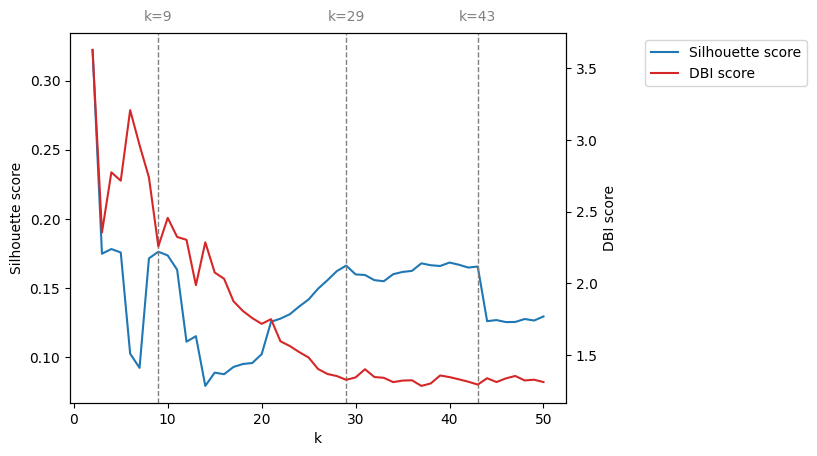

In [7]:
plotk(results_df, [9, 29, 43])

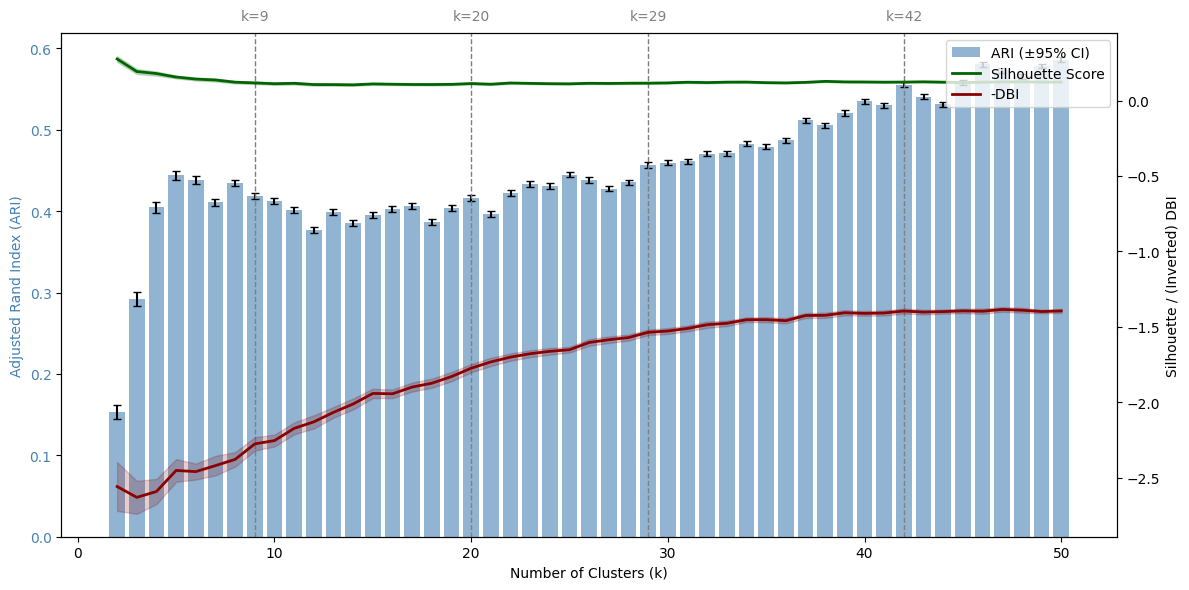

In [17]:
plot_clustering_metrics(metrics_df, vlines=[9, 20, 29, 42])

### K = 9

In [45]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 9)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_43F_9C_NOD_1_genepy.txt", sep='\t', index=False)

In [43]:
X.var()

ENSG00000023445_BIRC3_CADD15_matrix      0.004218
ENSG00000055208_TAB2_CADD15_matrix       0.005355
ENSG00000064012_CASP8_CADD15_matrix      0.005686
ENSG00000091106_NLRC4_CADD15_matrix      0.005849
ENSG00000091592_NLRP1_CADD15_matrix      0.005923
ENSG00000100324_TAB1_CADD15_matrix       0.006030
ENSG00000100906_NFKBIA_CADD15_matrix     0.003758
ENSG00000101966_XIAP_CADD15_matrix       0.005375
ENSG00000103313_MEFV_CADD15_matrix       0.007348
ENSG00000103490_PYCARD_CADD15_matrix     0.002541
ENSG00000104312_RIPK2_CADD15_matrix      0.009332
ENSG00000104365_IKBKB_CADD15_matrix      0.004067
ENSG00000105483_CARD8_CADD15_matrix      0.004591
ENSG00000106100_NOD1_CADD15_matrix       0.009360
ENSG00000110330_BIRC2_CADD15_matrix      0.006215
ENSG00000112062_MAPK14_CADD15_matrix     0.003752
ENSG00000112851_ERBIN_CADD15_matrix      0.009615
ENSG00000118503_TNFAIP3_CADD15_matrix    0.003759
ENSG00000125538_IL1B_CADD15_matrix       0.000916
ENSG00000127837_AAMP_CADD15_matrix       0.008552


In [41]:
km_out_sparc.value_counts().sort_values(ascending=False)

Cluster
4          1877
5           356
6           181
0           113
2            93
1            88
3            71
7            49
8            28
Name: count, dtype: int64

In [46]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(5.302445067455746e-12), np.float64(8.56736119006894e-11), np.float64(1.5180953978306167e-06)]


### K = 20

In [7]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 20)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_43F_20C_NOD_1_genepy.txt", sep='\t', index=False)

In [48]:
km_out_sparc.value_counts().sort_values(ascending=False)

Cluster
4          1182
13          422
5           202
2           200
10          123
14           85
15           81
6            80
1            79
3            63
0            60
19           49
17           41
7            41
16           38
9            29
8            28
11           25
12           20
18            8
Name: count, dtype: int64

In [9]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [18]:
#feat_imp_sparc[(feat_imp_sparc['Importance'] <= 0.60) & (feat_imp_sparc['Importance'] >= 0.10)]
feat_imp_sparc[feat_imp_sparc['Feature'] == 'ENSG00000185386_MAPK11_CADD15_matrix']
#feat_imp_sparc[feat_imp_sparc['Cluster'] == 6]

,Feature,Importance,Cluster
12,ENSG00000185386_MAPK11_CADD15_matrix,0.014875,0
44,ENSG00000185386_MAPK11_CADD15_matrix,0.064710,1
105,ENSG00000185386_MAPK11_CADD15_matrix,0.007752,2
142,ENSG00000185386_MAPK11_CADD15_matrix,0.011780,3
195,ENSG00000185386_MAPK11_CADD15_matrix,0.003638,4
234,ENSG00000185386_MAPK11_CADD15_matrix,0.006540,5
271,ENSG00000185386_MAPK11_CADD15_matrix,0.012318,6
315,ENSG00000185386_MAPK11_CADD15_matrix,0.009938,7
361,ENSG00000185386_MAPK11_CADD15_matrix,0.006481,8
396,ENSG00000185386_MAPK11_CADD15_matrix,0.015367,9


In [49]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(5.450685684832581e-08), np.float64(3.8639605286011207e-08), np.float64(4.42928518845155e-09)]


### K = 29

In [50]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 29)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_43F_29C_NOD_1_genepy.txt", sep='\t', index=False)

In [51]:
km_out_sparc.value_counts().sort_values(ascending=False)

Cluster
4          1021
21          248
8           186
20          184
2           162
19          108
27          102
6            71
1            70
7            66
10           58
3            52
0            48
9            47
15           44
11           44
12           41
16           41
5            34
18           34
17           30
24           29
25           26
26           24
13           23
14           20
23           18
28           13
22           12
Name: count, dtype: int64

In [12]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [14]:
feat_imp_sparc[(feat_imp_sparc['Importance'] <= 0.60) & (feat_imp_sparc['Importance'] >= 0.10)]

,Feature,Importance,Cluster
86,ENSG00000165416_SUGT1_CADD15_matrix,0.565631,2
129,ENSG00000091592_NLRP1_CADD15_matrix,0.506387,3
172,ENSG00000104312_RIPK2_CADD15_matrix,0.137360,4
173,ENSG00000167207_NOD2_CADD15_matrix,0.121013,4
301,ENSG00000156711_MAPK13_CADD15_matrix,0.596903,7
387,ENSG00000142405_NLRP12_CADD15_matrix,0.556957,9
688,ENSG00000137757_CASP5_CADD15_matrix,0.483369,16
860,ENSG00000104312_RIPK2_CADD15_matrix,0.454733,20
1161,ENSG00000103313_MEFV_CADD15_matrix,0.537659,27


In [52]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(4.865065037848071e-05), np.float64(3.3882652844573593e-06), np.float64(0.001956346548345874)]


### K = 42

In [53]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 42)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_43F_42C_NOD_1_genepy.txt", sep='\t', index=False)

In [54]:
km_out_sparc.value_counts().sort_values(ascending=False)

Cluster
4          747
21         216
31         145
8          143
20         136
2          126
16         100
19         100
27          93
6           79
35          70
3           58
10          57
36          45
1           44
11          43
9           43
15          41
12          40
33          39
7           39
30          37
18          31
39          31
37          30
24          28
17          27
32          26
25          24
26          24
29          22
13          22
38          20
41          19
14          19
23          18
5           14
0           13
40          13
28          13
22          12
34           9
Name: count, dtype: int64

In [55]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.0006300609379317237), np.float64(4.510762127396548e-09), np.float64(0.00028949430597332556)]


### Other K

In [ ]:
# k = 16
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 16)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
#km_out.value_counts()

In [ ]:
feat_imp = KM_RF(km_out_sparc, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Diagnosis']['corr_p_values_chi2']

In [ ]:
results_df['Crohn s disease phenotype']['corr_p_values_chi2']

In [ ]:
results_df['IBD surgery final']['corr_p_values_chi2']

In [ ]:
#Cluster 1
#NOD2 70.22% -> 0.1323 - 0.3652
#SUGT1 3.96% -> <= 0.2013
#ERBIN 2.67% ->  <= 0.3058
#MAPK12 2.09% -> <= 0.2843
#NOD1 1.75% -> <= 0.2768
#RELA 1.69% -> 0
#BIRC3 1.69% -> 0
#NLRP1 1.43% -> <= 0.2021
#CASP8 1.32% -> <= 0.09
SotonIBD_CADD15_GenePy['Cluster 1'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.132311468176971) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.365205488832726)
                                       & (SotonIBD_CADD15_GenePy['ENSG00000165416_SUGT1'] <= 0.201280690665366) & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.375835188227294)&
                                       (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.284265744209123) & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.276787154268017) &
                                       (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000023445_BIRC3'] == 0) &
                                       (SotonIBD_CADD15_GenePy['ENSG00000091592_NLRP1'] <= 0.202101747859509)).astype(int)

In [ ]:
#Cluster 5
#NOD2 46.21% -> 0
#SUGT1 13.83% -> <= 0.007
#ERBIN 5.16% -> <= 0.3254
#MAPK12 4.22% -> <= 0.2843
#NOD1 3.65% -> <= 0.3178
#RELA 3.59% -> 0
#NRLP1 3.15% -> <= 0.2021
#CARD9 2.84% -> 0
#BIRC3 2.31% -> 0
#TAB1 2.12% -> 0
#CARD8 1.77% -> 0
#NLRP7 1.31% -> 0
SotonIBD_CADD15_GenePy['Cluster 5'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000165416_SUGT1'] <= 0.0070120773143289)
                                       & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.325406754325555)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.284265744209123)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.317840326123237) & (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] == 0)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000091592_NLRP1'] <= 0.202101747859509)&(SotonIBD_CADD15_GenePy['ENSG00000187796_CARD9'] == 0) &
#                                       (SotonIBD_CADD15_GenePy['ENSG00000023445_BIRC3'] == 0)& (SotonIBD_CADD15_GenePy['ENSG00000100324_TAB1'] == 0) &
#                                       (SotonIBD_CADD15_GenePy['ENSG00000105483_CARD8'] == 0)
                                       ).astype(int)

In [ ]:
#Cluster 13
#NOD2 76.41% -> >= 0.3585
#ERBIN 2.08% -> <= 0.5793
#NOD1 1.88% -> <= 0.5118
#CASP9 1.62% -> <= 0.6922
#NLRP12 1.42% <= 0.4622
#MAPK12 1.37% -> <= 0.44
#RELA 1.17% -> <= 0.4136
#CARD6 1.07% -> <= 0.4563
SotonIBD_CADD15_GenePy['Cluster 13'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.358468103620945) & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.579367065203214) &
                                        (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.511821245992663) & (SotonIBD_CADD15_GenePy['ENSG00000132906_CASP9'] <= 0.692219162925112)
                                        & (SotonIBD_CADD15_GenePy['ENSG00000142405_NLRP12'] <= 0.462179899117249)&
                                        (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.442011527819315) & (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] <= 0.41358255389904) &
                                        (SotonIBD_CADD15_GenePy['ENSG00000132357_CARD6'] <= 0.456358576821125)
                                        ).astype(int)

In [ ]:
cont_table = pd.crosstab(SotonIBD_CADD15_GenePy['Cluster 1'], SotonIBD_CADD15_GenePy['IBD Surgery'])
#Remove IBDU
#cont_table = cont_table.iloc[:,[0,3]]
#chi square
chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
p_value

In [ ]:
# k = 38
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 38)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Crohn s disease phenotype']['overall_p_value']

In [ ]:
results_df['Diagnosis'].keys()

## 13 NOD Signalling Genes

In [99]:
#Check top 20 features with highest variance from consensus NOD signalling genes
#SPARC IBD
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 2)
sparc_ibd_NOD_sig20=X.var().sort_values(ascending=False)[0:20].index

#Soton IBD
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 2, "Soton")
soton_ibd_NOD_sig20=X.var().sort_values(ascending=False)[0:20].index

intersection=set(sparc_ibd_NOD_sig20.str.split("_CADD15_matrix").str[0]) & set(soton_ibd_NOD_sig20)
NOD_sig_genes13=NOD_sig_genes43[NOD_sig_genes43['Gene stable ID'].isin(pd.DataFrame(intersection)[0].str.split("_").str[0])]
NOD_sig_genes13.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes13.txt", index=False, sep="\t")

In [187]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes12, 50, "SPARC", n_iter=100)
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig13_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig12_clustering_metrics.txt", sep="\t", index=False)

In [144]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.401805,2.604172,2547
1,3,0.304363,2.150568,2213
2,4,0.241007,1.951068,1952
3,5,0.250578,1.794640,1914
4,6,0.201277,2.021615,1590
5,7,0.204379,1.888264,1576
6,8,0.204533,1.466519,1525
7,9,0.216493,1.440575,1348
8,10,0.226625,1.335454,1325
9,11,0.186902,1.497866,1325


In [189]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.225422,0.383789,0.010695,0.329396,0.093823,0.018710,1.946570,0.555648,0.110808
1,3,0.435365,0.301565,0.008404,0.270302,0.058553,0.011677,1.910575,0.330648,0.065938
2,4,0.461506,0.225102,0.006273,0.260081,0.059927,0.011951,1.821437,0.278371,0.055513
3,5,0.439493,0.184712,0.005147,0.246381,0.067785,0.013518,1.747807,0.225403,0.044950
4,6,0.469036,0.158463,0.004416,0.239849,0.062024,0.012369,1.638109,0.190427,0.037975
5,7,0.464820,0.152508,0.004250,0.229026,0.053902,0.010749,1.565339,0.150636,0.030040
6,8,0.467198,0.155076,0.004322,0.221485,0.045236,0.009021,1.491951,0.145745,0.029065
7,9,0.477753,0.154290,0.004300,0.229301,0.048949,0.009761,1.428297,0.133821,0.026687
8,10,0.474717,0.154462,0.004304,0.221287,0.043929,0.008760,1.384043,0.115623,0.023058
9,11,0.492963,0.158066,0.004405,0.227880,0.040186,0.008014,1.312264,0.113258,0.022586


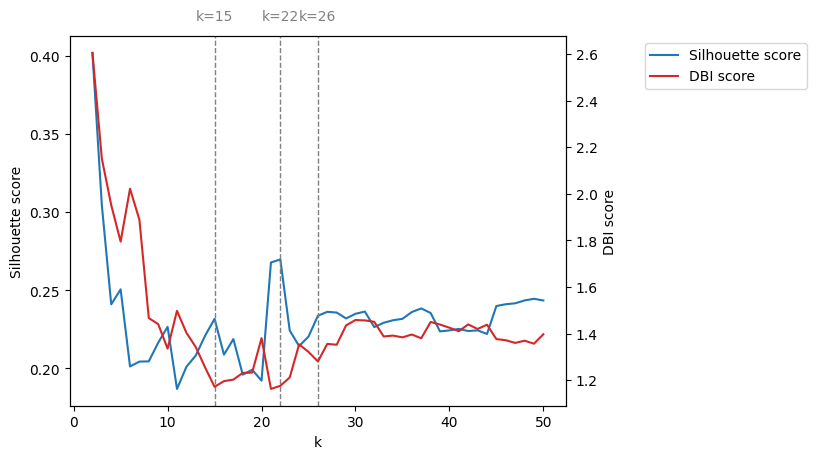

In [156]:
plotk(results_df, [15, 22, 26])

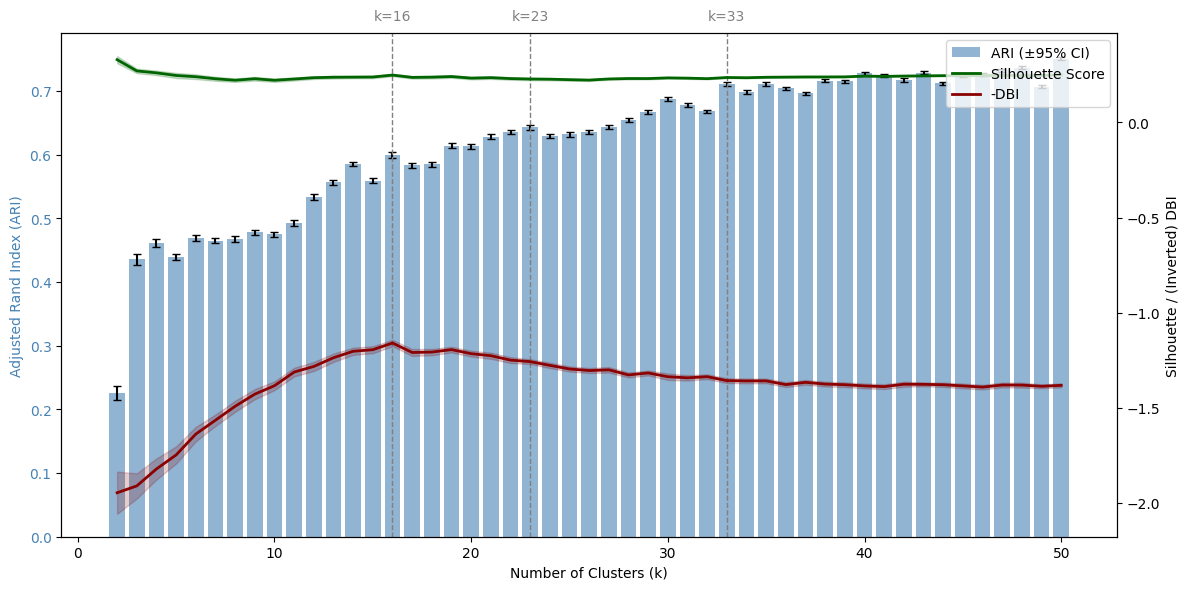

In [188]:
plot_clustering_metrics(metrics_df, vlines=[16, 23, 33])

### K = 16

In [190]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 16)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_13F_16C_NOD_1_genepy.txt", sep='\t', index=False)

In [192]:
km_out_sparc.value_counts().sort_values(ascending=False)

Cluster
15         848
2          430
0          379
8          221
10         199
1          156
7           84
4           84
6           82
13          79
5           69
11          61
9           47
3           45
12          37
14          35
Name: count, dtype: int64

In [193]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(1.2110045815789265e-12), np.float64(7.56994345103035e-11), np.float64(6.925181244091584e-06)]


### K = 23

In [194]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 23)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)

In [195]:
km_out_sparc.value_counts().sort_values(ascending=False)

Cluster
22         694
0          299
2          276
6          214
18         181
11         159
1          121
8          120
4           83
19          81
9           79
12          74
21          64
17          59
15          57
7           55
10          51
20          46
3           46
16          29
13          27
14          22
5           19
Name: count, dtype: int64

In [196]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(2.3674660165204144e-08), np.float64(2.2956321211021183e-09), np.float64(1.581016440908152e-05)]


### K = 33

In [197]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 33)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_13F_33C_NOD_1_genepy.txt", sep='\t', index=False)

In [198]:
km_out_sparc.value_counts().sort_values(ascending=False)

Cluster
22         620
32         198
18         159
25         155
31         139
11         132
0          118
2          114
1          114
23         106
29          86
6           83
4           82
9           79
12          72
19          68
21          58
7           54
17          53
27          51
10          50
3           46
20          42
28          36
8           34
16          29
26          20
5           19
13          13
15          11
30           6
14           5
24           4
Name: count, dtype: int64

In [199]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(5.956702190069134e-07), np.float64(4.003080903964134e-08), np.float64(6.813890987214432e-05)]


## 49 IL-10 Signalling Genes

In [100]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, IL10_sig_genes_49, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, "SPARC", n_iter=100)
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_IL10sig49_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [101]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.261718,1.923151,2544
1,3,0.315420,2.301088,2532
2,4,0.274240,2.046551,2272
3,5,0.276645,1.915903,2238
4,6,0.113642,2.206678,1696
5,7,0.115621,2.107094,1686
6,8,0.119634,2.135421,1642
7,9,0.126868,1.983770,1599
8,10,0.081303,2.296428,810
9,11,0.109451,2.167079,1094


In [102]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.082400,0.256945,0.007160,0.304793,0.110309,0.021998,1.923240,0.897043,0.178889
1,3,0.263531,0.342368,0.009541,0.220950,0.099462,0.019835,2.179873,0.747543,0.149076
2,4,0.300549,0.270061,0.007526,0.161071,0.093628,0.018671,2.350221,0.654412,0.130504
3,5,0.321765,0.252855,0.007046,0.155239,0.085448,0.017040,2.202468,0.486712,0.097061
4,6,0.320233,0.216508,0.006034,0.128659,0.073114,0.014580,2.229763,0.395975,0.078966
5,7,0.348313,0.200793,0.005596,0.134622,0.067114,0.013384,2.089907,0.356107,0.071015
6,8,0.376928,0.200150,0.005578,0.109936,0.049646,0.009901,2.133045,0.301278,0.060081
7,9,0.383490,0.196886,0.005487,0.100728,0.030438,0.006070,2.087309,0.242051,0.048270
8,10,0.424841,0.191398,0.005334,0.111492,0.034396,0.006859,1.954726,0.197685,0.039423
9,11,0.422353,0.181144,0.005048,0.111924,0.030869,0.006156,1.893001,0.176582,0.035214


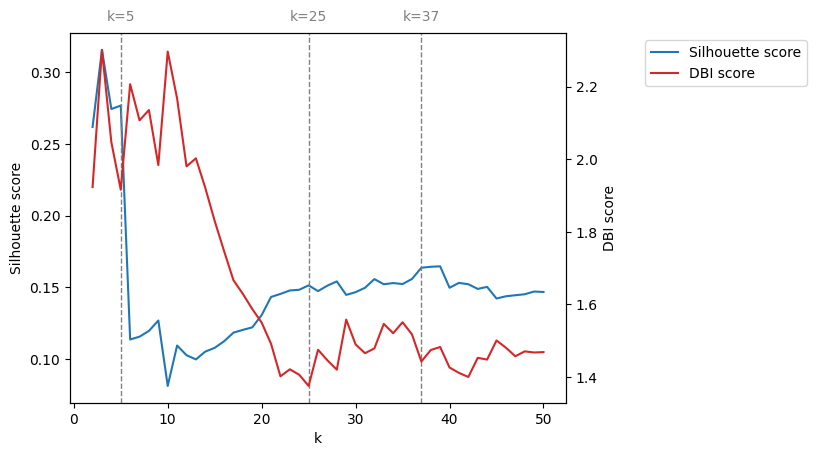

In [107]:
plotk(results_df, [5, 25, 37])

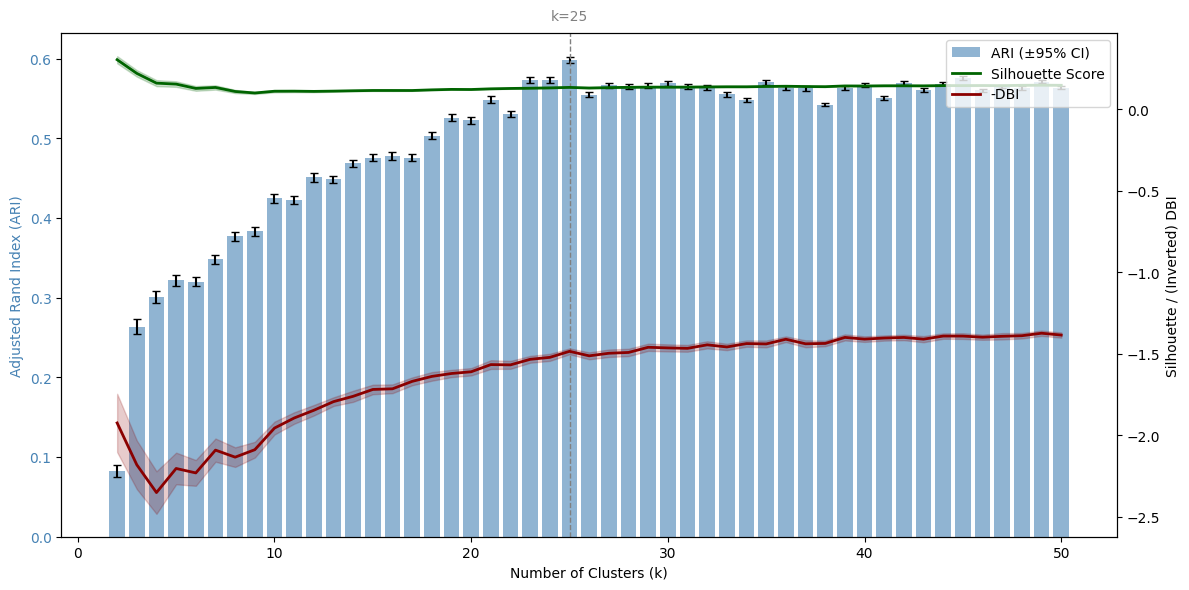

In [110]:
plot_clustering_metrics(metrics_df, vlines=[25])

### K = 25

In [113]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, IL10_sig_genes_49, 20)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_47F_25C_IL10_1_genepy.txt", sep='\t', index=False)

,ENSG00000006451_RALA_CADD15_matrix,ENSG00000064666_CNN2_CADD15_matrix,ENSG00000070831_CDC42_CADD15_matrix,ENSG00000089157_RPLP0_CADD15_matrix,ENSG00000090013_BLVRB_CADD15_matrix,ENSG00000099810_MTAP_CADD15_matrix,ENSG00000100292_HMOX1_CADD15_matrix,ENSG00000106605_BLVRA_CADD15_matrix,ENSG00000110324_IL10RA_CADD15_matrix,ENSG00000110711_AIP_CADD15_matrix,...,ENSG00000177156_TALDO1_CADD15_matrix,ENSG00000180370_PAK2_CADD15_matrix,ENSG00000182718_ANXA2_CADD15_matrix,ENSG00000196262_PPIA_CADD15_matrix,ENSG00000197632_SERPINB2_CADD15_matrix,ENSG00000232810_TNF_CADD15_matrix,ENSG00000240972_MIF_CADD15_matrix,ENSG00000243646_IL10RB_CADD15_matrix,ENSG00000244067_GSTA2_CADD15_matrix,ENSG00000291237_SOD2_CADD15_matrix
samid,,,,,,,,,,,,,,,,,,,,,
10150028,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.135554,0.0,0.0,0.0,...,0.0,0.0,0.000000,0,0.000000,0.0,0.0,0.136692,0.0,0.0
10150030,0.0,0.0,0.000000,0.0,0.000000,0.115697,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0,0.000000,0.0,0.0,0.136692,0.0,0.0
10150035,0.0,0.0,0.000000,0.0,0.000000,0.093963,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0,0.103721,0.0,0.0,0.136692,0.0,0.0
10150036,0.0,0.0,0.000000,0.0,0.000000,0.093963,0.297749,0.0,0.0,0.0,...,0.0,0.0,0.000000,0,0.000000,0.0,0.0,0.000000,0.0,0.0
10150186,0.0,0.0,0.000000,0.0,0.000000,0.093963,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9649776,0.0,0.0,0.264495,0.0,0.000000,0.093963,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0,0.000000,0.0,0.0,0.224657,0.0,0.0
9650147,0.0,0.0,0.000000,0.0,0.000000,0.093963,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0,0.103721,0.0,0.0,0.136692,0.0,0.0
9650172,0.0,0.0,0.264495,0.0,0.000000,0.115697,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.158816,0,0.000000,0.0,0.0,0.000000,0.0,0.0


## IL-10 Signalling Genes

In [133]:
#Check top 20 features with highest variance from consensus IL-10 signalling genes
#SPARC IBD
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, IL10_sig_genes_49, 2)
sparc_ibd_IL10_sig20=X.var().sort_values(ascending=False)[0:20].index

#Soton IBD
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, IL10_sig_genes_49, 2, "Soton")
soton_ibd_IL10_sig20=X.var().sort_values(ascending=False)[0:20].index

intersection=set(sparc_ibd_IL10_sig20.str.split("_CADD15_matrix").str[0]) & set(soton_ibd_IL10_sig20)
IL10_sig_genes13=IL10_sig_genes_49[IL10_sig_genes_49['Gene stable ID'].isin(pd.DataFrame(intersection)[0].str.split("_").str[0])]
IL10_sig_genes13.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL10_sig_genes13.txt", index=False, sep="\t")

## Other Pathways

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NADPH_genes_36, 50, cohort_name='SPARC')

In [ ]:
results_df

In [ ]:
plotk(results_df)

In [ ]:
#k = 32
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NADPH_genes_36, 24)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)


In [ ]:
#km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_30F_32C_JAK_STAT_genepy.txt", sep='\t', index=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['Crohn s disease phenotype']['overall_p_value'])
print(results_df['IBD surgery final']['overall_p_value'])

## 34 Consensus IBD Genes

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, IBD_union_genes_sparc, 50, cohort_name='SPARC')

In [ ]:
plotk(results_df, [28, 35, 40])

In [ ]:
# k = 40
km_out, X = KM(SPARC_IBD_CADD15_GenePy, IBD_union_genes_sparc, 40)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 17].value_counts('Crohn s disease phenotype', normalize=True)

In [ ]:
km_out_phen_GenePy.value_counts('Crohn s disease phenotype', normalize=True)

In [ ]:
feat_imp = KM_RF(km_out, X)

In [ ]:
#len(feat_imp[feat_imp['Importance'] >= 0.1]['Feature'].unique())
feat_imp[feat_imp['Cluster'] == 22]

In [ ]:
results_chi2 = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_chi2['Diagnosis']['p_values_chi2']

In [ ]:
results_chi2['Diagnosis']['residuals']

In [ ]:
results_chi2['Crohn s disease phenotype']['p_values_chi2']

In [ ]:
results_chi2['Crohn s disease phenotype']['residuals']

In [ ]:
results_chi2['IBD surgery final']['p_values_chi2']

In [ ]:
results_chi2['Diagnosis'].keys()

# Southampton IBD

## NOD2

In [ ]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD2_gene, 50, cohort_name='Soton')

In [ ]:
results_df

In [ ]:
plotk(results_df, [13, 20, 38])

In [ ]:
#k = 13
km_out, X = KM(SotonIBD_CADD15_GenePy, NOD2_gene, 13, "Soton")
km_out_phen_GenePy = merge_phen_genepy(km_out, SotonIBD_CADD15_GenePy, X, "Soton")

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/Soton_KMeans_NOD2_13C_genepy.txt", sep='\t', index=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'IBD phenotype', 'IBD Surgery', 'Granuloma'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['IBD phenotype']['overall_p_value'])
print(results_df['IBD Surgery']['overall_p_value'])
print(results_df['Granuloma']['overall_p_value'])

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] ==5 ]['ENSG00000167207.15_NOD2'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 5]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 12) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['IBD phenotype'].value_counts()


## 9 NOD Signalling Genes

In [10]:
#results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='Soton')
metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 50, "Soton", n_iter=100)

In [17]:
metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig8_clustering_metrics.txt", sep="\t", index=False) #No IKBKG GenePy

In [14]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.311966,0.424856,0.011840,0.493945,0.118800,0.023691,1.073603,0.391217,0.078017
1,3,0.558969,0.280720,0.007823,0.444341,0.069026,0.013765,1.069780,0.279243,0.055687
2,4,0.576375,0.269632,0.007514,0.436055,0.090221,0.017992,1.000535,0.263186,0.052485
3,5,0.602198,0.247743,0.006904,0.426758,0.087902,0.017530,0.950822,0.210189,0.041916
4,6,0.609700,0.235305,0.006557,0.418156,0.086052,0.017161,0.898692,0.160665,0.032040
5,7,0.601560,0.212089,0.005910,0.406852,0.077650,0.015485,0.879487,0.142248,0.028367
6,8,0.667450,0.218653,0.006093,0.419245,0.055829,0.011133,0.830753,0.111325,0.022201
7,9,0.724649,0.211719,0.005900,0.421446,0.040592,0.008095,0.811920,0.080354,0.016024
8,10,0.780982,0.192196,0.005356,0.428920,0.036066,0.007192,0.789915,0.081626,0.016278
9,11,0.722705,0.205741,0.005733,0.432840,0.037975,0.007573,0.767367,0.075599,0.015076


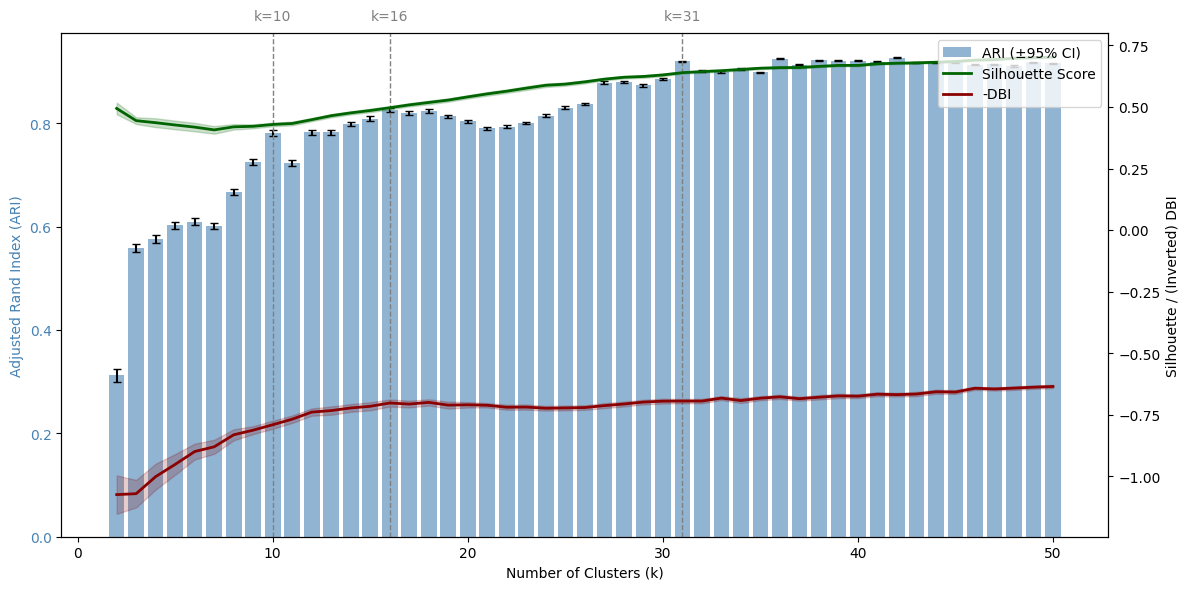

In [15]:
#plotk(results_df,[21, 25, 32])
plot_clustering_metrics(metrics_df, vlines=[10, 16, 31])

### K = 10

In [27]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 10, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_8F_10C_NOD_2_genepy.txt", sep='\t', index=False)

In [29]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
7          437
0          341
2          157
5          137
1           72
4           17
6           16
9           13
3            9
8            5
Name: count, dtype: int64

In [30]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(4.054205655831338e-05), np.float64(0.003634260704992003), np.float64(0.24138354819905394)]


### K = 16

In [31]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 16, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_8F_16C_NOD_2_genepy.txt", sep='\t', index=False)

In [32]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
7          324
0          276
13         175
2          129
5          127
15          47
14          33
1           28
6           16
4           14
9           13
3            9
8            5
11           3
12           3
10           2
Name: count, dtype: int64

In [8]:
feat_imp_soton = KM_RF(km_out_soton, X)

In [33]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.00015443048994188938), np.float64(0.044441988852929507), np.float64(0.289205714355346)]


### K = 31

In [36]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 31, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, "Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_8F_31C_NOD_2_genepy.txt", sep='\t', index=False)

In [37]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
7          188
17         166
18         136
15         112
0           99
28          61
13          53
2           47
30          47
12          46
25          44
21          33
6           30
20          25
1           23
5           14
27          13
22          12
10          11
3            9
23           8
4            6
24           5
19           3
8            3
9            2
11           2
14           2
29           2
16           1
26           1
Name: count, dtype: int64

In [ ]:
feat_imp = KM_RF(km_out, X)

In [39]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery', 'Granuloma'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.006471740744602885), np.float64(0.5993829021614572), np.float64(0.5004954399299243)]


In [ ]:
### NOD2 analysis
#Sort clusters by feature importance of NOD2 CADD15 GenePy
feat_imp[feat_imp['Feature'] == "ENSG00000167207.15_NOD2"].sort_values(by="Importance", ascending=False)

In [ ]:
feat_imp[feat_imp['Cluster'] == 17].sort_values(by="Importance", ascending=False)

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 9]['ENSG00000187796.16_CARD9'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 20]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 7) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['IBD phenotype'].value_counts()


In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 21].value_counts(['Diagnosis', 'Crohn s disease phenotype', "IBD surgery final"])

In [ ]:
#Check raw and multiple-test-corrected p-values
results_df['Granuloma']['overall_p_value']#.keys()

## 43 NOD Signalling Genes

In [57]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 50, cohort_name='Soton')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 50, "Soton", n_iter=100)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig43_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [59]:
#results_df
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.092559,0.257246,0.007169,0.281677,0.131451,0.026214,1.892077,0.749225,0.149411
1,3,0.253054,0.266805,0.007435,0.187283,0.071427,0.014244,2.188739,0.471659,0.094059
2,4,0.277258,0.235389,0.006560,0.161693,0.066180,0.013198,2.090923,0.393742,0.078521
3,5,0.311100,0.202738,0.005650,0.143055,0.046130,0.009199,2.074310,0.326562,0.065124
4,6,0.329029,0.196500,0.005476,0.135245,0.042143,0.008404,1.988204,0.290603,0.057953
5,7,0.358019,0.191361,0.005333,0.132780,0.035380,0.007055,1.913277,0.232161,0.046298
6,8,0.404588,0.180948,0.005043,0.132584,0.025204,0.005026,1.861826,0.224973,0.044864
7,9,0.382207,0.163863,0.004566,0.130816,0.026296,0.005244,1.819004,0.192124,0.038314
8,10,0.372740,0.155819,0.004342,0.130247,0.024235,0.004833,1.769946,0.178067,0.035510
9,11,0.370357,0.143197,0.003991,0.132243,0.019928,0.003974,1.718196,0.157681,0.031445


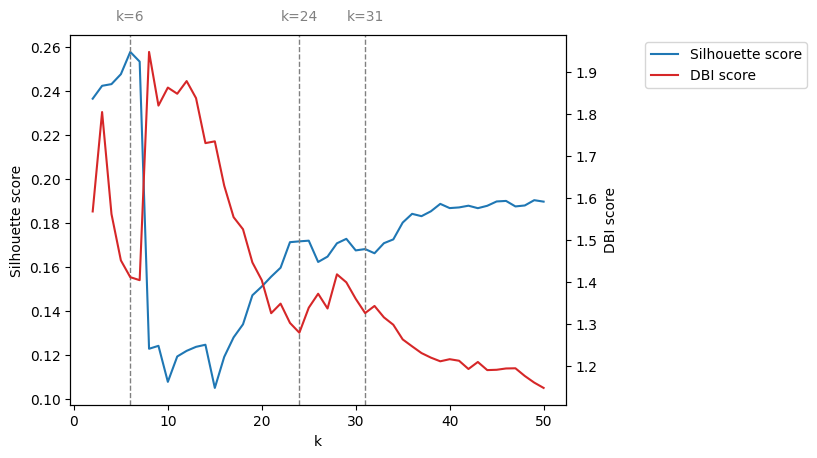

In [13]:
plotk(results_df, [6, 24, 31])

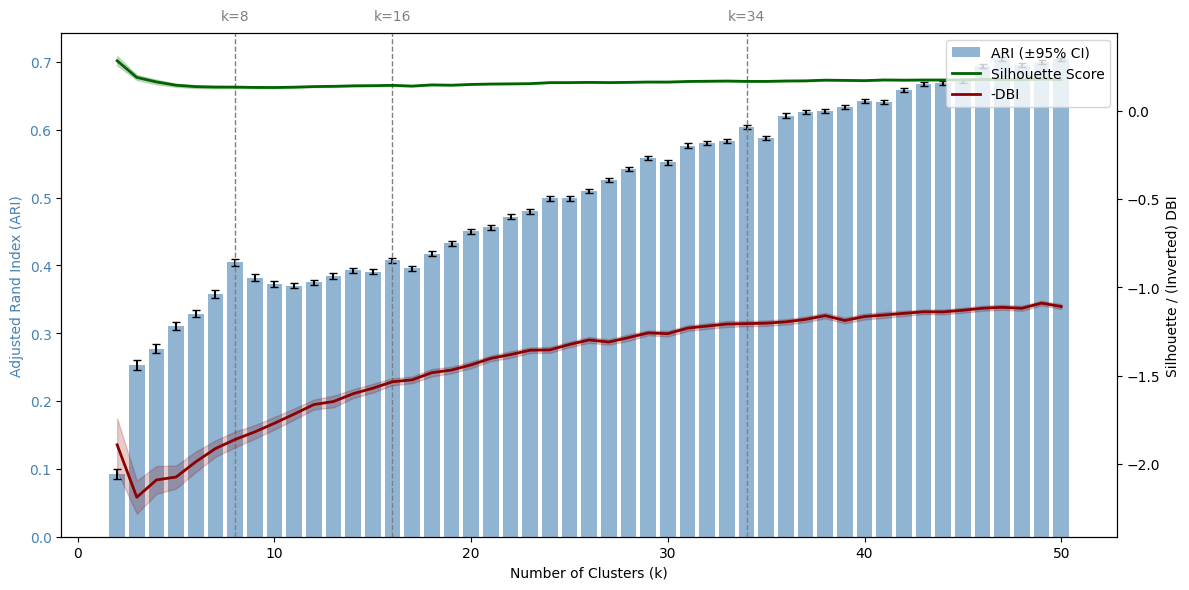

In [58]:
plot_clustering_metrics(metrics_df, vlines=[8, 16, 34])

### K = 8

In [60]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 8, "Soton") #39 genes; missing IL-18, NLRP7, NAIP, IKBKG
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_39F_8C_NOD_1_genepy.txt", sep='\t', index=False)

In [61]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
0          643
3          256
6          106
1           65
4           63
7           30
2           23
5           18
Name: count, dtype: int64

In [62]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.0007763280841172049), np.float64(0.4145599248603509), np.float64(0.22802980035484882)]


### K = 16

In [11]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 16, "Soton") #39 genes; missing IL-18, NLRP7, NAIP, IKBKG
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_39F_16C_NOD_1_genepy.txt", sep='\t', index=False)

In [64]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
0          264
3          160
12         154
14         136
11         110
10          90
6           72
4           60
1           57
7           29
2           21
5           17
8           15
9           11
15           7
13           1
Name: count, dtype: int64

In [12]:
feat_imp_soton = KM_RF(km_out_soton, X)

In [19]:
feat_imp_soton[feat_imp_soton['Feature'] == "ENSG00000185386_MAPK11"]

,Feature,Importance,Cluster
2,ENSG00000185386_MAPK11,0.137771,0
47,ENSG00000185386_MAPK11,0.011578,1
88,ENSG00000185386_MAPK11,0.015058,2
121,ENSG00000185386_MAPK11,0.044731,3
171,ENSG00000185386_MAPK11,0.007812,4
209,ENSG00000185386_MAPK11,0.007562,5
241,ENSG00000185386_MAPK11,0.014137,6
277,ENSG00000185386_MAPK11,0.018177,7
326,ENSG00000185386_MAPK11,0.007035,8
365,ENSG00000185386_MAPK11,0.008989,9


In [65]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.010447079660019128), 1.0, np.float64(0.14233174423692618)]


### K = 34

In [66]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 34, "Soton")  #39 genes; missing IL-18, NLRP7, NAIP, IKBKG
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv(
    "C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_39F_34C_NOD_1_genepy.txt",
    sep='\t', index=False)

In [67]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
0          282
11         102
24          92
18          91
6           72
21          71
5           68
13          60
25          47
20          41
28          32
3           26
12          21
4           18
16          17
19          15
8           15
33          15
7           14
22          13
1           11
27          11
9           11
29          10
14           9
31           8
15           7
17           7
32           5
2            4
26           4
10           2
23           2
30           1
Name: count, dtype: int64

In [68]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.012049100302356766), np.float64(0.37281968447184943), np.float64(0.7615671957240344)]


## 13 NOD Signalling Genes

In [200]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes13, 50, cohort_name='Soton')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes12, 50, "Soton", n_iter=100)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig13_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig12_clustering_metrics.txt", sep="\t", index=False)

In [166]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.250050,1.709517,1048
1,3,0.295217,1.560395,1019
2,4,0.309807,1.530167,981
3,5,0.301900,1.318814,963
4,6,0.156540,1.713131,694
5,7,0.169326,1.568265,688
6,8,0.264622,1.090292,725
7,9,0.277653,1.048867,714
8,10,0.248788,1.082856,682
9,11,0.261601,1.012050,675


In [203]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.149266,0.312633,0.008712,0.322967,0.120353,0.024001,1.673319,0.533652,0.106422
1,3,0.297797,0.261411,0.007285,0.256095,0.069671,0.013894,1.688237,0.304829,0.060789
2,4,0.322482,0.221213,0.006165,0.233078,0.067482,0.013457,1.652972,0.272081,0.054259
3,5,0.376397,0.205339,0.005722,0.229512,0.053425,0.010654,1.526896,0.201832,0.040250
4,6,0.382561,0.190638,0.005313,0.223899,0.046877,0.009348,1.452718,0.183194,0.036533
5,7,0.393440,0.186382,0.005194,0.214908,0.039596,0.007896,1.417422,0.173851,0.034670
6,8,0.433645,0.182537,0.005087,0.229244,0.035889,0.007157,1.294645,0.142658,0.028449
7,9,0.422370,0.160308,0.004467,0.226627,0.031574,0.006296,1.259096,0.113651,0.022664
8,10,0.440281,0.158431,0.004415,0.225278,0.028389,0.005661,1.226537,0.108352,0.021608
9,11,0.468411,0.154913,0.004317,0.234026,0.024610,0.004908,1.185225,0.108516,0.021640


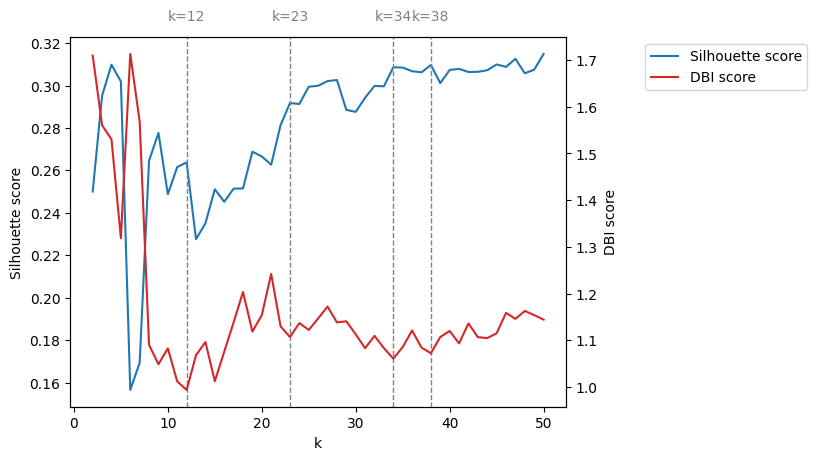

In [201]:
plotk(results_df, [12, 23, 34, 38])

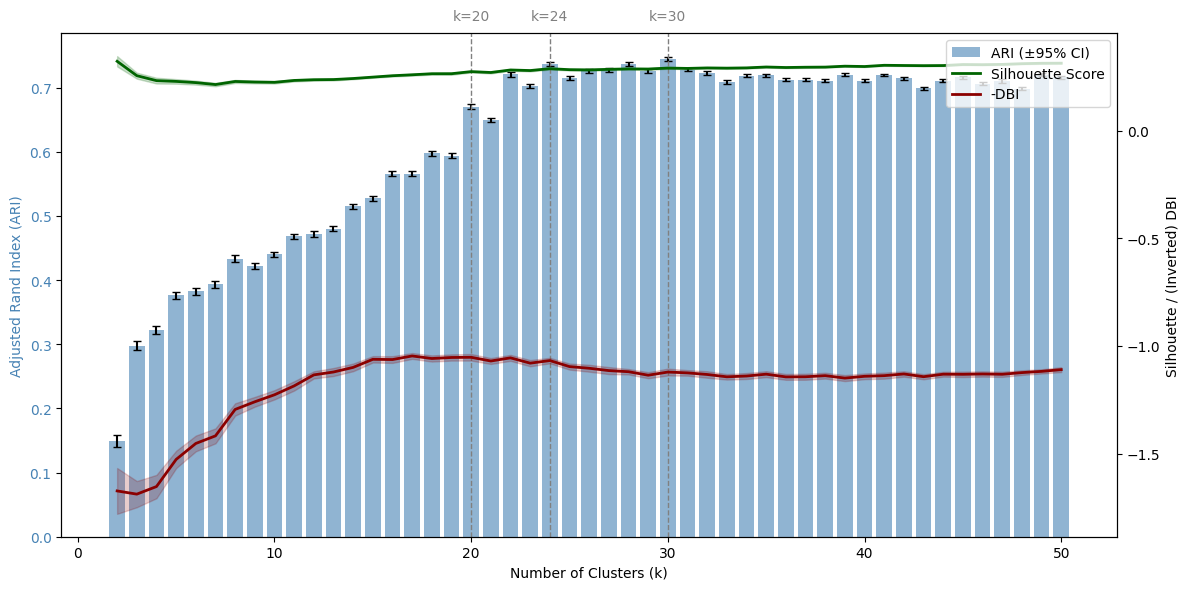

In [202]:
plot_clustering_metrics(metrics_df, vlines=[20, 24, 30])

### K = 20

In [204]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes13, 20, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")

In [205]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
0          341
11         184
9          101
18          80
3           72
16          69
15          60
4           56
17          52
2           44
13          27
14          23
12          22
5           18
7           14
19          13
6           11
1            8
10           7
8            2
Name: count, dtype: int64

In [206]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.003300624582797643), np.float64(0.11038193361728878), np.float64(0.6768849250328663)]


### K = 24

In [207]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes13, 24, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_13F_24C_NOD_1_genepy.txt", sep='\t', index=False)

In [208]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
0          242
20         133
18         112
3           95
7           79
6           74
12          71
15          68
22          48
17          44
19          43
10          28
21          23
5           22
4           18
2           17
9           16
14          15
8           14
11          13
23           9
1            8
13           7
16           5
Name: count, dtype: int64

In [209]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.009727035783110436), 1.0, np.float64(0.8514588219826823)]


### K = 30

In [210]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes13, 30, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")

In [211]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
28         123
20         122
0          113
18         107
3           95
22          86
6           73
15          59
25          52
19          43
17          43
7           38
10          28
12          25
21          23
26          19
5           19
4           18
24          17
9           16
2           15
14          15
8           14
11          12
23           9
13           7
29           6
16           5
1            1
27           1
Name: count, dtype: int64

In [212]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.0016219358512000507), 1.0, np.float64(0.43392426301644527)]


## 49 IL-10 Signalling Genes

In [114]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, IL10_sig_genes_49, 50, cohort_name='Soton')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 50, "Soton", n_iter=100)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_IL10sig49_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [115]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.412161,1.149382,1172
1,3,0.307847,1.333067,1091
2,4,0.322483,1.209639,1068
3,5,0.331046,1.116364,1059
4,6,0.349963,1.112876,1005
5,7,0.156444,2.130212,681
6,8,0.117569,2.087190,428
7,9,0.132525,1.922385,434
8,10,0.135221,1.851623,432
9,11,0.139965,1.724626,397


In [116]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.060915,0.226401,0.006309,0.409922,0.111414,0.022218,1.408873,0.782703,0.156088
1,3,0.165540,0.272666,0.007598,0.324479,0.098674,0.019678,1.601551,0.642496,0.128127
2,4,0.180721,0.243028,0.006773,0.268551,0.124054,0.024739,1.798816,0.711059,0.141800
3,5,0.220192,0.233597,0.006510,0.252540,0.118552,0.023642,1.695008,0.555654,0.110809
4,6,0.251875,0.230473,0.006423,0.247871,0.115064,0.022946,1.610028,0.447021,0.089146
5,7,0.259636,0.217966,0.006074,0.225789,0.111709,0.022277,1.601222,0.383111,0.076401
6,8,0.350577,0.231153,0.006442,0.198987,0.090336,0.018015,1.607455,0.296766,0.059182
7,9,0.391460,0.236301,0.006585,0.208066,0.094027,0.018751,1.491494,0.271108,0.054065
8,10,0.434985,0.243710,0.006792,0.195675,0.082249,0.016402,1.467959,0.218846,0.043643
9,11,0.461057,0.229825,0.006405,0.197326,0.071088,0.014176,1.411031,0.212270,0.042331


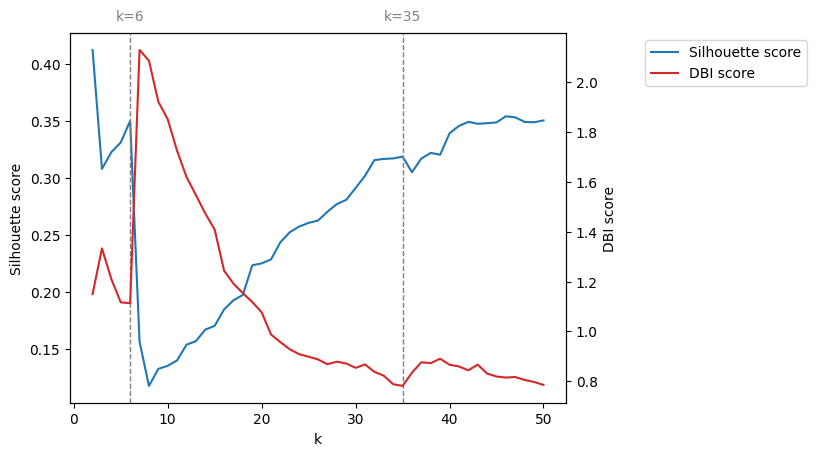

In [121]:
plotk(results_df, [6, 35])

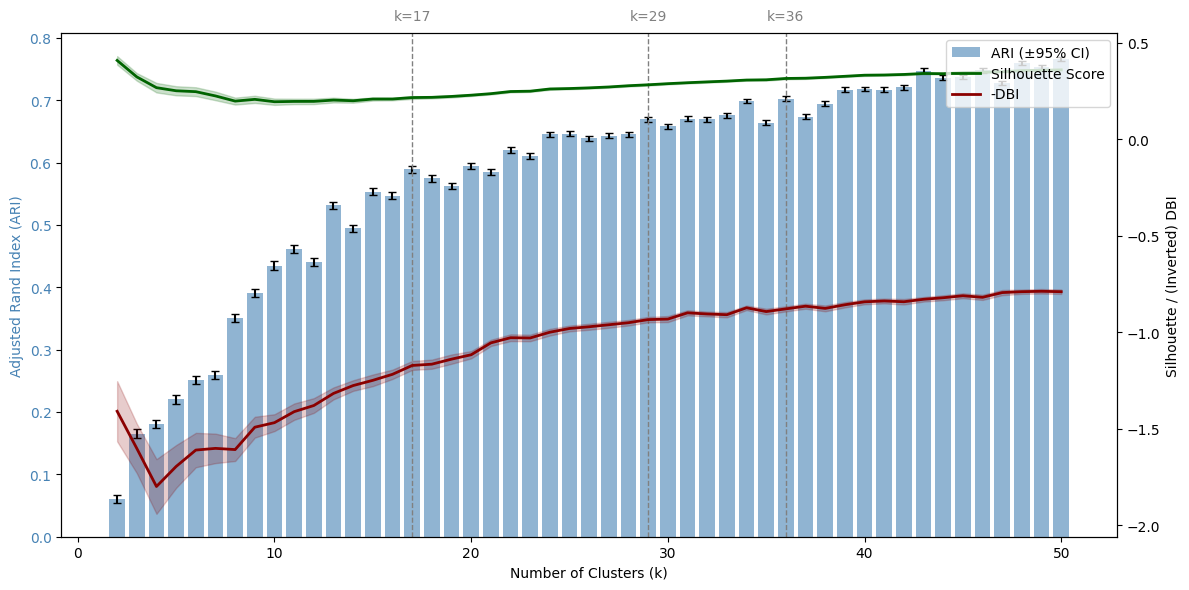

In [125]:
plot_clustering_metrics(metrics_df, vlines=[17, 29, 36])

### K = 29

In [128]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, IL10_sig_genes_49, 29, "Soton") #42 genes
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_42F_29C_IL10_1_genepy.txt", sep='\t', index=False)

In [127]:
X

,ENSG00000006451_RALA,ENSG00000064666_CNN2,ENSG00000070831_CDC42,ENSG00000090013_BLVRB,ENSG00000099810_MTAP,ENSG00000100292_HMOX1,ENSG00000106605_BLVRA,ENSG00000110324_IL10RA,ENSG00000110711_AIP,ENSG00000113013_HSPA9,...,ENSG00000172757_CFL1,ENSG00000174238_PITPNA,ENSG00000177156_TALDO1,ENSG00000180370_PAK2,ENSG00000182718_ANXA2,ENSG00000196262_PPIA,ENSG00000197632_SERPINB2,ENSG00000243646_IL10RB,ENSG00000244067_GSTA2,ENSG00000291237_SOD2
Samid,,,,,,,,,,,,,,,,,,,,,
AP0013,0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.069502,0.000000,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0
AP0030,0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.069502,0.000000,0.0,0.0,0.0,0,0.0,0.119176,0.0,0.0
AP0045,0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.036693,0.000000,0.0,0.0,0.0,0,0.0,0.195869,0.0,0.0
AP0046,0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.069502,0.000000,0.0,0.0,0.0,0,0.0,0.119176,0.0,0.0
AP0065,0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.119176,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SORL0037,0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.036693,0.000000,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0
SORL0038,0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.069502,0.384629,0.0,0.0,0.0,0,0.0,0.119176,0.0,0.0
SORL0039,0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.036693,0.000000,0.0,0.0,0.0,0,0.0,0.119176,0.0,0.0
